# 4. Modelling, Evaluations and Findings

## Imports and Reading In

Again, we will use interactive plots for our numerical data. **You'll be able to zoom in and mouse over the distributions to see value counts.**

**For the visualizations to work, please install the libraries at your command line/terminal using:**

    pip install plotly
    pip install cufflinks
    pip install squarify

In [1]:
#the usual dataframe and visualization imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#plotly, squarify and cufflinks interactive chart imports

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.express as px #another related library of plotly that makes it easy to draw multiple plots
import squarify

#we have to make sure this code is run for Jupyter Notebooks otherwise the plots may not happen offline:
init_notebook_mode(connected=True)
cf.go_offline()

In [2]:
#expand column width

pd.set_option("display.max_colwidth", 500)

In [3]:
#importing modeling libraries

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm, linear_model, metrics
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
df = pd.read_csv("../data/df_processed.csv")

In [5]:
#since we're only looking at 2 subreddits, we can just convert the subreddit column to a binary variable 
#using dummy encoding (n-1 columns)

subs = df[['subreddit']]
dummied = pd.get_dummies(subs, drop_first=True) #drop first = true because we aren't one-hot encoding
df["subreddit_datascience"]=dummied

df.drop('subreddit', axis = 1, inplace = True)

In [6]:
df.info()

#seems we have one NaN title.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1286 entries, 0 to 1285
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   title                  1286 non-null   object
 1   link_flair_text        1286 non-null   object
 2   selftext               1286 non-null   object
 3   score                  1286 non-null   int64 
 4   url                    1286 non-null   object
 5   num_comments           1286 non-null   int64 
 6   cleaned_text           1286 non-null   object
 7   cleaned_title          1285 non-null   object
 8   subreddit_datascience  1286 non-null   uint8 
dtypes: int64(2), object(6), uint8(1)
memory usage: 81.8+ KB


In [7]:
#okay it seems the reason why our cleaned_title returned a NaN is because the original title comprises stop words.

df[df.isnull().any(axis=1)] 

,title,link_flair_text,selftext,score,url,num_comments,cleaned_text,cleaned_title,subreddit_datascience
177,Who are you?,Discussion,I'm really interested in getting an idea of who is a part of this community and where they are right now.\n\n[View Poll](https://www.reddit.com/poll/gu1iqk),3,https://www.reddit.com/r/datascience/comments/gu1iqk/who_are_you/,8,really interested getting idea part community right view poll http www reddit com poll gu iqk,NaN,1


In [8]:
#we will just fill it with the word "none" since the content of the original title does not suggest much meaning

df.fillna(value="none", inplace = True)
df.loc[[177]]

,title,link_flair_text,selftext,score,url,num_comments,cleaned_text,cleaned_title,subreddit_datascience
177,Who are you?,Discussion,I'm really interested in getting an idea of who is a part of this community and where they are right now.\n\n[View Poll](https://www.reddit.com/poll/gu1iqk),3,https://www.reddit.com/r/datascience/comments/gu1iqk/who_are_you/,8,really interested getting idea part community right view poll http www reddit com poll gu iqk,none,1


In [9]:
#it looks to be in order - let's double check if no NaNs anywhere:

df.info()

#ok good to go. Moving on to the baseline score.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1286 entries, 0 to 1285
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   title                  1286 non-null   object
 1   link_flair_text        1286 non-null   object
 2   selftext               1286 non-null   object
 3   score                  1286 non-null   int64 
 4   url                    1286 non-null   object
 5   num_comments           1286 non-null   int64 
 6   cleaned_text           1286 non-null   object
 7   cleaned_title          1286 non-null   object
 8   subreddit_datascience  1286 non-null   uint8 
dtypes: int64(2), object(6), uint8(1)
memory usage: 81.8+ KB


## Baseline Score: Unoptimized Multinomial Bayes Modelling Accuracy is 0.868.

Recall the *first half* of our problem statement below:

"Can we create a Natural Language Processing model utilizing either MultiNomial Bayes or Logistic Regression to: 
* accurately predict whether a post is from r/DataScience or r/Analytics?"
    
Let's calculate the benchmark score or "baseline" score that our predictive models need to beat. For this project, we will use Multinomial Bayes without Grid Search CV optimization.

**What would be our baseline accuracy in predicting posts to be from r/datascience and *not* r/analytics using Multinomial Bayes from all text?**

In [10]:
#let's create an aggregated column of all words in post text and titles

df["all_words_clean"]=df["cleaned_text"]+ " " +df["cleaned_title"]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1286 entries, 0 to 1285
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   title                  1286 non-null   object
 1   link_flair_text        1286 non-null   object
 2   selftext               1286 non-null   object
 3   score                  1286 non-null   int64 
 4   url                    1286 non-null   object
 5   num_comments           1286 non-null   int64 
 6   cleaned_text           1286 non-null   object
 7   cleaned_title          1286 non-null   object
 8   subreddit_datascience  1286 non-null   uint8 
 9   all_words_clean        1286 non-null   object
dtypes: int64(2), object(7), uint8(1)
memory usage: 91.8+ KB


In [12]:
#assigning X and Y
X = df["all_words_clean"]
y = df["subreddit_datascience"]

In [13]:
#train test splitting using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [14]:
#we once again will convert our words into vectors
#intialize CountVectorizer and assign as vectorizer that will look at single words and bigrams
cvec = CountVectorizer(ngram_range=(1, 2))

In [15]:
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(),
                            columns=cvec.get_feature_names())

In [16]:
X_test_cvec = pd.DataFrame(cvec.transform(X_test).todense(),
                            columns=cvec.get_feature_names())

In [17]:
#Instantiating our Multinomial Bayes model

nb = MultinomialNB()
MNB_model= nb.fit(X_train_cvec, y_train) #fitting model to our train set
train_score = MNB_model.score(X_train_cvec, y_train) #scoring on train
test_score = MNB_model.score(X_test_cvec, y_test) #scoring on test.

print(f"training accuracy score is {train_score}")
print(f"test accuracy score is {test_score}")


training accuracy score is 0.9961089494163424
test accuracy score is 0.8488372093023255


**Our baseline score to beat is 0.868 using unoptimized MultiNomial Bayes, which is pretty high given that a perfect score of 1 (for perfect predictions) isn't all that far away.**

## Testing out Other Models

Let's try it with the TF-IDF weighting and also GridSearchCV.  We will create a pipeline to fit onto our model to make life easier, and build a function around it that lets you pick between Multinomial Bayes or SVM. It will also print all the metrics, and create a confusion matrix.

In [18]:
##takes 2 variables, predictor and classifier. Predictor = column name string; 
#classifier = either 1 for "bayes" or 2 for "svm"

def grid_modeller_scorer(predictor, classifier):
    X = df[predictor]
    y = df["subreddit_datascience"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)
    
    if classifier == 1:
        #create Multinomial Bayes pipeline using Count Vectorizer and TFIDF Vectorizer
        pipeline_bayes = Pipeline([("wordbag",TfidfVectorizer()), #word vectorizing into weighted token integers
                                    ("classifier",MultinomialNB()), #train on TF-IDF w Naive Bayes
                                    ])
        #run grid search on TFIDF Vectorizer parameters
        param_grid = {'wordbag__ngram_range':[(1,1),(1,2),(2,2)],'wordbag__max_features': [25, 50, 100,1000,10000]}
        gs = GridSearchCV(pipeline_bayes, param_grid, cv=3, n_jobs=-1, verbose=1) 
        gs.fit(X_train, y_train)
        
        #get scores
        gb_train_score = gs.score(X_train, y_train)
        gb_test_score = gs.score(X_test, y_test)
        
        #get confusion matrix and classification metrics
        y_pred = gs.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(cm, columns=["pred datascience","pred analytics"], index=["actual datascience","actual analytics"])
        
        #print out accuracy, estimator and parameters from GridSearchCV
        print(f'grid bayes best train score = {gb_train_score}')
        print(f'grid bayes best test score = {gb_test_score}')
        print(f'grid bayes best estimator = {gs.best_estimator_}')
        print(f'grid bayes best parameters = {gs.best_params_}')
        print(f"MNB Accuracy - how often is model correct?:",metrics.accuracy_score(y_test, y_pred))
        print(f"MNB Precision - ability not to label as positive a sample that is negative:",metrics.precision_score(y_test, y_pred))
        print(f"MNB Sensitivity or Recall - ability to find all the positive samples.:",metrics.recall_score(y_test, y_pred))
                
        #turns classification report into a dictionary from which we can print other metrics
        #then returns the actual dataframe of the confusion matrix        
       
        return cm_df
    
    elif classifier == 2:
        #create SVM pipeline using Count Vectorizer and TFIDF Transfformer
        pipeline_svm = Pipeline([("wordbag",TfidfVectorizer()), #word vectorizing into weighted token integers
                                 ("classifier",svm.SVC()), #train on TF-IDF w SVC
                                ])
        #run grid search on TFIDF Vectorizer and SVM parameters
        param_grid = {"wordbag__ngram_range":[(1,1),(1,2),(2,2)],"wordbag__max_features": [25, 50, 100,1000,10000], 
                      "classifier__C":[1,10], "classifier__gamma":[0.001, 0.01, 0.1, 1], 
                      "classifier__kernel":('linear', 'rbf','sigmoid','poly')}
        
        gs = GridSearchCV(pipeline_svm, param_grid, cv=3, n_jobs=-1, scoring = "accuracy", verbose=1) 
        gs.fit(X_train, y_train)
        
        #get scores
        svm_train_score = gs.score(X_train, y_train)
        svm_test_score = gs.score(X_test, y_test)
        
        #get confusion matrix and classification metrics
        y_pred = gs.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(cm, columns=["pred datascience","pred analytics"], index=["actual datascience","actual analytics"])
        
        #print out accuracy, estimator and parameters from GridSearchCV
        print(f'grid SVM best train score = {svm_train_score}')
        print(f'grid SVM best test score = {svm_test_score}')
        print(f'grid SVM best estimator = {gs.best_estimator_}')
        print(f'grid SVM best parameters = {gs.best_params_}')    
        #taken from datacamp tutorial: https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
        print("SVM Accuracy - how often is model correct?:",metrics.accuracy_score(y_test, y_pred))
        print("SVM Precision - ability not to label as positive a sample that is negative:",metrics.precision_score(y_test, y_pred))
        print("SVM Sensitivity or Recall - ability to find all the positive samples.:",metrics.recall_score(y_test, y_pred))
        
        return cm_df

### Grid-Search Optimized MultiNomial Bayes Model on All Text (Title + Posts)

In [25]:
#We run our function for Grid-Search Optimizied Multinomial Bayes on Post and Title text:
grid_modeller_scorer("all_words_clean", 1)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.9s finished


grid bayes best train score = 0.9747081712062257
grid bayes best test score = 0.8333333333333334
grid bayes best estimator = Pipeline(memory=None,
         steps=[('wordbag',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=10000,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
            

,pred datascience,pred analytics
actual datascience,117,18
actual analytics,25,98


### Grid-Search Optimized MultiNomial Bayes Model on Title Text only

We saw in our EDA that pretty unique keywords existed primarily in the title. Will that help our Bayesian model? Let's find out:

In [26]:
#Grid-Search Optimizied Multinomial Bayes on Title text only:
grid_modeller_scorer("cleaned_title", 1)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


grid bayes best train score = 0.9066147859922179
grid bayes best test score = 0.7868217054263565
grid bayes best estimator = Pipeline(memory=None,
         steps=[('wordbag',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=1000,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
             

[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.3s finished


,pred datascience,pred analytics
actual datascience,111,24
actual analytics,31,92


### Grid-Search Optimized Support Vector Machine Modelling on All Text (Title + Posts)

Let's now also run a giant function on All Text once again, but this time using Support Vector Machines:

In [27]:
grid_modeller_scorer("all_words_clean", 2)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.2min finished


grid SVM best train score = 0.9970817120622568
grid SVM best test score = 0.8527131782945736
grid SVM best estimator = Pipeline(memory=None,
         steps=[('wordbag',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=10000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 S

,pred datascience,pred analytics
actual datascience,108,27
actual analytics,11,112


### Grid-Search Optimized Support Vector Machine Modelling on Title Text Only

In [28]:
grid_modeller_scorer("cleaned_title", 2)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.1s finished


grid SVM best train score = 0.9912451361867705
grid SVM best test score = 0.7906976744186046
grid SVM best estimator = Pipeline(memory=None,
         steps=[('wordbag',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=10000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 S

,pred datascience,pred analytics
actual datascience,102,33
actual analytics,21,102


### Comparing Metrics Across All Models

We'll quickly create a pandas dataframe of our modelling results. For the purposes of predicting whether a post is either from datascience or analytics, we will look at the following metrics:

   1. **Train and Test Score Accuracy**: this simply tells us how close a value is to its true value. It's only concerned with the percentage of posts correctly predicted as coming from datascience or analytics.
   
   2. **Precision**: this talks about how precise/accurate our model is - out of those posts predicted as data science posts, how many of them are actually from data science and not analytics? Precision is a good measure to determine, when the costs of False Positive is important. 
   
I argue that not just accuracy but **precision** also matters because too often, analytics is confused with data science. If we can have a better capability reducing false positivies, we prevent confusion of analytics posts with datascience posts. We can then obtain greater clarity not just in our evaluation of how good our model is, but in understanding the substantive keywords that separate the 2 concepts academically and professionally.

In [21]:
# printing train score, test score, test error and precision 
model_name = ["TFIDF Multinomial Bayes - All Text", "TFIDF Multinomial Bayes - Title Only", 
              "TFIDF SVM - All Text", "TFIDF SVM - Title Only"]
train = [0.975, 0.907, 0.997, 0.991] 
test = [0.833,0.787,0.853,0.791] 

#import operator module to allow for mathematical subtraction of lists: 
#https://stackoverflow.com/questions/23173294/how-to-mathematically-subtract-two-lists-in-python
#https://docs.python.org/2/library/functions.html#map

import operator

test_error = list(map(operator.sub, train, test))
precision = [0.845,0.793,0.806,0.756] 


# dictionary of lists  
dict = {'model': model_name, 'train accuracy': train, 'test accuracy': test, 'test error':test_error, 'precision':precision}  
    
eval_df = pd.DataFrame(dict) 
    
eval_df  

,model,train accuracy,test accuracy,test error,precision
0,TFIDF Multinomial Bayes - All Text,0.975,0.833,0.142,0.845
1,TFIDF Multinomial Bayes - Title Only,0.907,0.787,0.120,0.793
2,TFIDF SVM - All Text,0.997,0.853,0.144,0.806
3,TFIDF SVM - Title Only,0.991,0.791,0.200,0.756


Against our baseline score of `0.868`, the best performing models are SVM models, with train scores equally high at 0.991 for either title/all text features.

**We see that the test error between train and test scores are between 0.12 to 0.2 despite Grid Searched Cross Validation. This implies that the majority of our models are overfit, except for Multinomial Bayes All Text. We can infer that high variance is difficult to reduce when one vectorizes out between 1000-10000 words and bigrams.**

Although the All-Text SVM model is the most accurate train score at `0.997`, it has the second highest test error and precision is `0.806`, which is lower than All-Text Multinomial Bayes. Although All-Text MNB has slightly reduced accuracy, it makes up for this with lower test error at `0.142` and has the highest precision at `0.845`. In theory, this means that the model should be both accurate and utilize distinct keywords that will help us predict whether a post is talking about data science, and not analytics. 

Given our special focus on precision because of our problem statement's intention to dispel confusion between analytics vs data science, we will use `TFIDF Multinomial Bayes - All Text` as our **production model**. Accordingly, we're going to now visualize our top words using the parameters this model's TFIDFVectorizer was trained on. 

## Visualizing Top Words Used by our Production Model, TFIDF Multinomial Bayes - All Text

We will recycle our painstakingly crafted visualization functions from our previous notebook to create treemap and bar chart plots to visualize top `/r/datascience` words below:

In [22]:
#Assign data science posts to extract top words 
all_text = df["cleaned_text"]

#instantiate another TFIDFVectorizer that now uses parameters of production model divined earlier 
#from our "best features" output
vectorizer =TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [20]:
#turn a series into vectors and then plot the distribution of the top 25 words

def vector_barplotter(series, graph_title, x_label):
    vectorized_series = vectorizer.fit(series)
    series_df = pd.DataFrame(vectorizer.transform(series).todense(),
                              columns=vectorizer.get_feature_names())
    #we slice the top 25 words 
    top_25_words=series_df.sum().sort_values(ascending = False).head(25)
    
    #we plot this on a plotly bar chart by frequency of words.
    fig = px.bar(top_25_words, orientation='v', title = graph_title, 
             labels={"index":x_label})
    fig.show()

In [21]:
#to plot a square word treemap, I have to modify our datascience word array into a special dataframe; 
#Adapted from https://python-graph-gallery.com/200-basic-treemap-with-python/
#We plot a square treemap of word frequencies, as an alternative to word clouds
#to save time I turned this into a function too.

def vector_treemap_plotter(series, graph_title):
    vectorized_series = vectorizer.fit(series)
    series_df = pd.DataFrame(vectorizer.transform(series).todense(),
                              columns=vectorizer.get_feature_names())
    #we slice the top 25 words and turn that into a squarify-friendly dataframe
    top_25_words=series_df.sum().sort_values(ascending = False).head(25)
    top_25_words_df = pd.DataFrame(top_25_words)
    top_25_words_df.columns = ["count"]
    top_25_words_df["word"]=top_25_words_df.index
    top_25_words_df = top_25_words_df.reset_index(drop=True)
    
    count = top_25_words_df["count"]
    word = top_25_words_df["word"]
    
    #I then create a hybrid heatmap and treemap
    #it is like a word cloud, but it looks cleaner.
    #frequent words are deeper blues with bigger squares.

    cmap = matplotlib.cm.Blues
    mini=min(count)
    maxi=max(count)
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in count]

    squarify.plot(sizes=count, norm_x=100, norm_y=100, label=word, 
                  color=colors,alpha=.9 )
    
    plt.axis('off')
    plt.show()
    
    print(graph_title)

In [25]:
vector_barplotter(all_text, "Top Words used by Production Model to Identify /r/datascience Posts and Titles", "words")

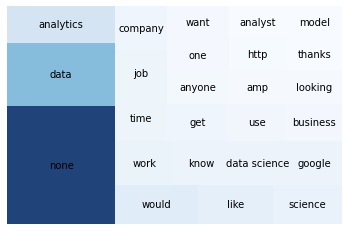

Top Words used by Production Model in /r/datascience Posts and Titles


In [27]:
#this plot once again represents the same data as the bar chart above; just more compactly.
vector_treemap_plotter(all_text, "Top Words used by Production Model in /r/datascience Posts and Titles")

Unfortunately, apart from the obvious references to "data science" and "analytics", **there isn't much special in the keywords used**. It looks similar to our general top keywords taken from earlier EDA and Visualizations. What we can understand, however, is that the `analytics` keyword and the `data` keyword play special importance in distinguishing between the two types of subreddits. 

**This means there is a difference between having a high scoring, highly accurate predicting a model, or having a model that provides better keywords to understand our 2 concepts better**

## Our Dilemma - Accurate Prediction vs Garnering More Knowledge from Keywords

Looking at the visualizations above and recalling our problem statement, we've definitely identified a very accurate model, but it seems that it doesn't take much more than identifying super obvious words/bigrams like `data` or `analytics` for our production model to distinguish either concept/subreddit with high accuracy.

If we repeat the **Problem Statement** again:

"Can we create a Natural Language Processing model utilizing either Multinomial Bayes or Support Vector Machines to:

* **accurately predict whether a post is from r/DataScience or r/Analytics, and** 
* use the better performing model's key words to **distinguish what conceptual and technical differences exist between Data Science vs Analytics** through keyword analysis of the two subreddits, 
* **in order to make concrete recommendations to students and professionals interested in either topic?"**

This means our production model only addresses the first of our objectives. We're not gaining enough new information from keyword analysis of a super accurate model to fulfill the second nor third objectives.

We must therefore find a compromise. We had earlier divined from our intitial EDA in the previous notebook that top keywords in `titles` are way more *informative*. 

Let us return to our performance evaluation table, and **re-pick a model that is trained on post `titles` that hopefully is not abhorrently inaccurate.**

In [28]:
#running our previously created table on title-trained models only
eval_df.iloc[[1,3]]

,model,train accuracy,test accuracy,test error,precision
1,TFIDF Multinomial Bayes - Title Only,0.907,0.787,0.12,0.793
3,TFIDF SVM - Title Only,0.991,0.791,0.20,0.756


Looking at performance of our Title-focused models again, we see that the Title Only SVM model is most accurate with a score of `0.991`. **we will re-pick `TFIDF SVM - Title Only` as our *secondary* production model for purely informative keywords.** 

**Again, our baseline score is 0.868; our secondary production model still scores well at 0.991 from an accuracy standpoint. However, to meet the second and third problem statement goal of finding more unique keywords to differentiate analysts from data scientists, it means this title-focused secondary model is necessary.**

We will now plot the top keywords used after we change the WordVectorizer parameters to those utilized by the secondary model:

In [22]:
#best TFIDF parameters of SVM seconday model trained only on titles is different than the production model 
#this model only wants single words and no bigrams as best parameters
vectorizer =TfidfVectorizer(max_features=10000, ngram_range=(1, 1))

ds_titles = df["cleaned_title"][df["subreddit_datascience"]==1] #array of datascience titles
an_titles = df["cleaned_title"][df["subreddit_datascience"]==0] #array of analytics titles

## Visualizing Top Words Used by our Secondary Keyword-Focused Model in All Post Titles

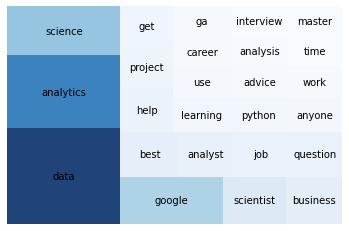

Top keywords used by our Secondary Model in Post Titles in both subreddits


In [23]:
#we plot a treemap that shows the same data above in an alternate way above.
vector_treemap_plotter(df['cleaned_title'], "Top keywords used by our Secondary Model in Post Titles in both subreddits")

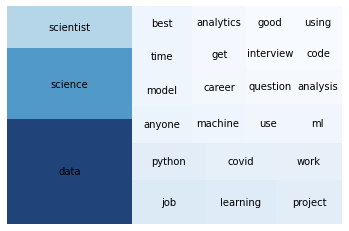

Top keywords used by our Secondary Model in Post Titles in r/datascience only


In [31]:
vector_treemap_plotter(ds_titles, "Top keywords used by our Secondary Model in Post Titles in r/datascience only")

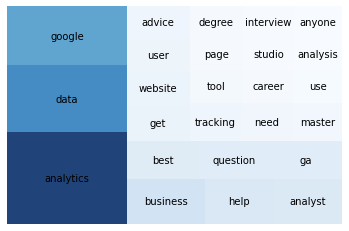

Top keywords used by our Secondary Model in Post Titles in r/analytics


In [32]:
vector_treemap_plotter(an_titles, "Top keywords used by our Secondary Model in Post Titles in r/analytics")

## Findings and Recommendations


Even after training models, we still find that the top words in post titles here are identical to those we already identified briefly in EDA. 

**/r/analytics**: very specific unique words like **google** and **analytics** appear, as does **ga** (short for Google Analytics, not the school!).

**/r/datascience**: again, there is clearly a focus on words like **python, learning ("machine learning")**, and even **job + interview**. With python and machine learning, it's pretty self-explanatory why we focus on these terms. The focus on words like **project** also obviously reflect the teamwork and group projects that data scientists work on. However, we already stated that the surprising mention of **covid** is curious - is it a large focus for data scientists now? 

### Analytics Keywords: Google and Web Analytics

Google Analytics is the most popular web analytics platform that tracks and reports website traffic, currently as a platform inside the Google Marketing Platform brand: http://w3techs.com/technologies/overview/traffic_analysis/all.
 
The high frequency of the "google" and "google analytics" keywords points directly to the software's importance in the job of Analysts - in particular Web Analysts. 

This also explains why "tracking" and "user" are keywords in /r/analytics - they have to do with the tracking of user acquisition and behaviour, usually in the interest of optimizing and monitoring digital marketing campaigns centred around Google Ads. 

That is already very different from what we do as data scientists. Google Analytics concerns itself with the live tracking of the success of digital marketing campaigns e.g. "how many users clicked on my website today?"; data scientists focus on training statistical machine learning models to predict a regression or classification-based problem that is not restricted to website usage.

**Recommendation 1**: For marketing professionals and students, it would be extremely useful to study Google Analytics, as this can augment either their existing skillset or their future work. Google provides a free Analytics Academy portal to learn more about the subject:https://analytics.google.com/analytics/academy/.

### Analytics Keywords: Business Analytics and Business Analyst 

Google doesn't have the monopoly on all analytics platforms, though. Keywords like "Business Analytics" and the occupation of Business Analyst concern the general functional role of examining past business performance to drive business planning:https://en.wikipedia.org/wiki/Business_analytics

Data scientists are not confined to business data alone. Business Analysts also use structured data and statistics, and while the statistical overlap exists with Data Science too, there former has little to no coding involved. There is also a perception that Business Analysts are "closer" to business decision-making processes than data scientists: https://www.mygreatlearning.com/blog/difference-between-data-science-business-analytics/#:~:text=Data%20Science%20vs%20Business%20Analytics%2C%20often,interchangeably%2C%20are%20very%20different%20domains.&text=Simply%20put%2C%20Data%20science%20is,business%20decisions%20for%20the%20company;

However, there are exceptions, and data scientists can also be directly involved in business decision-making: https://towardsdatascience.com/data-science-for-decision-makers-7248beddf948

**Recommendation 2**: There are plenty of courses out there focusing on Analytics toolkits like Excel Analysis ToolPak, or visualization tools like Tableau or PowerBI for generating dashboard and visualizations to communicate analysis results - with the clear result being that "anybody with minimal or no coding background can learn analytics":https://medium.com/@springboard_ind/data-science-vs-data-analytics-how-to-decide-which-one-is-right-for-you-41e7bdec080e#:~:text=It%20uses%20existing%20information%20to,needed%20answering%20to%20drive%20innovation.

### Data Science Keywords: COVID?

The obvious words we are familiar with include machine learning, python and data science. However, is COVID a large enough concern to become a domain unto itself that data scientists ought to explore? The short answer is yes: https://www.orange-business.com/en/blogs/ai-and-data-science-tool-battle-covid-19,

Orange Business Services describes how statistical machine learning has been used for disease modeling, in order to predict "where the next pandemic will arrive and the impact it will have". According to them, the significance of Data Science in this regard is not just the technical capacity of what we do, but how it can encourage early detection.

Given the enormous interest in COVID recorded in tracking data (https://trends.google.com/trends/story/US_cu_4Rjdh3ABAABMHM_en),  it's no surprise then that planning ahead for how to avoid another pandemic has been underway. Perhaps data scientists wanting to work on the most contemporary issue affecting everybody now (as of June 2020) could think of starting to reserch medical data science.

**Recommendation 3**: Data scientists who want to make a direct contribution to fighting COVID can actually partake in a Kaggle competition that can "help the medical community develop answers to high priority scientific questions": https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge. Within it contains the CORD-19 dataset, which "represents the most extensive machine-readable coronavirus literature collection available for data mining to date." This is as good a starting point as any keen to help their community, or at the very least enhance their resume with contemporary work.


## Summary

That concludes our project. We began by framing the problem statement, which has 3 goals: accurate subreddit post prediction, clarifying the differences between data science vs analytics, and the formulating of recommendations inferred from said differences.

After cleaning, exploratory data analysis (with custom functions creating multiple visualizations) and textual pre-processing, we created a Natural Language Processing using Multinomial Bayes as a baseline model, and beat its score using a TFIDF Multinomial Bayes Model focuses on all text. We achieved superior predictive accuracy, but realized that accuracy and deriving unique and informative keywords are mutually exclusive.

To that end, we re-trained our models on titles, which took a hit on accuracy, but were rewarded with better keywords. It's important to note that the baseline score was still beaten even by our less accurate secondary model. 

We took external research on those keywords to draw some key differences to help answer what the difference is between Analytics and Data Science, and even uncovered a trending focus on COVID in data science. We followed this with practical recommendations to both students and professionals. 

### Future Steps:

To make this project even more useful especially with respect to our initial obstacle of getting more unique keywords, we could get more data. This can be done by expanding our model to other subreddits that concern either data science or analytics, like r/MachineLearning or r/BusinessIntelligence. 

We could also scrape from other websites like LinkedIn, by scraping both Data Analyst/Business Analyst and Data Science job descriptions, or even LinkedIn profiles of people who hold those titles. 